# Model Comparison: Baseline vs PANN

Comprehensive comparison of baseline black-box model and physics-informed neural network (PANN) on seen and unseen scenarios.

**Key approach**: Two-stage data splitting with scenario-based evaluation:
1. Manual scenario selection (training vs test-only scenarios)
2. Separate evaluation on seen (training scenarios) and unseen (test-only) scenarios
3. Direct comparison of generalization capabilities

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import load_dataset, prepare_data_by_groups, get_component_names
from src.models.base_model import build_model, train_model, evaluate_model, load_trained_model
from src.models.pann_model import build_pann_model, train_pann_model
from src.comparison import (
    compare_predictions,
    compare_residuals,
    compare_metrics,
    generate_comparison_summary,
    plot_error_distribution_comparison
)

plt.rcParams['figure.figsize'] = (12, 4)

/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Configuration: Select Training and Test Scenarios

In [2]:
# Training scenarios (good coverage)
training_scenarios = [
    'uniaxial_x',
    'uniaxial_y',
    'uniaxial_x_compression',
    'uniaxial_y_compression',
    'biaxial_2to1',
    'pure_shear',
    'simple_shear'
]

# Test scenarios (for final evaluation)
test_only_scenarios = [
    'sphere',
    'equibiaxial',
    'equibiaxial_compression',
    'phi_45_plane',
    'radial_45_45'
]

RANDOM_STATE = 42

print("Training on:", training_scenarios)
print("Testing on:", test_only_scenarios)

Training on: ['uniaxial_x', 'uniaxial_y', 'uniaxial_x_compression', 'uniaxial_y_compression', 'biaxial_2to1', 'pure_shear', 'simple_shear']
Testing on: ['sphere', 'equibiaxial', 'equibiaxial_compression', 'phi_45_plane', 'radial_45_45']


## 1. Load Data

In [3]:
data_path = '../../neohookean-data-generator/data/consolidated_all.npz'

dataset = load_dataset(data_path)

print(f"Dataset loaded: {dataset['n_samples']} samples")

strain_names, stress_names = get_component_names()

strains = dataset['strains']
stresses = dataset['stresses']
scenario_labels = dataset['scenario_labels']
case_ids = dataset['case_ids']

# Create masks for training and test scenarios
train_mask = np.isin(scenario_labels, training_scenarios)
test_mask = np.isin(scenario_labels, test_only_scenarios)

# Extract training data and metadata
X_train_scenarios = strains[train_mask]
y_train_scenarios = stresses[train_mask]
case_ids_train = case_ids[train_mask]

# Extract unseen test data
X_test_unseen = strains[test_mask]
y_test_unseen = stresses[test_mask]

print(f"Training scenarios data: {len(X_train_scenarios)} samples")
print(f"Test-only scenarios data: {len(X_test_unseen)} samples")

Dataset loaded: 15925 samples
Training scenarios data: 4375 samples
Test-only scenarios data: 11550 samples


## 2. Case-Based Split Within Training Scenarios

In [4]:
# Prepare data for baseline (scaled) and PANN (unscaled)
# Both use same train/val/test split (by case) for fair comparison
data_baseline = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=True, split_by='case'
)

data_pann = prepare_data_by_groups(
    X_train_scenarios, y_train_scenarios, case_ids_train,
    test_size=0.2, val_size=0.2, random_state=RANDOM_STATE,
    scale=False, split_by='case'
)

# Prepare unseen test data for both models
data_baseline_unseen = {
    'X_test': data_baseline['X_scaler'].transform(X_test_unseen),
    'y_test': data_baseline['y_scaler'].transform(y_test_unseen),
    'y_test_original': y_test_unseen,
    'X_scaler': data_baseline['X_scaler'],
    'y_scaler': data_baseline['y_scaler']
}

data_pann_unseen = {
    'X_test': X_test_unseen,
    'y_test': y_test_unseen,
    'y_test_original': y_test_unseen,
    'X_scaler': None,
    'y_scaler': None
}

print(f"Train samples: {data_baseline['splits']['train']}")
print(f"Val samples:   {data_baseline['splits']['val']}")
print(f"Test (seen scenarios):   {data_baseline['splits']['test']}")
print(f"Test (unseen scenarios): {len(X_test_unseen)}")

Splitting by case: 175 unique groups
  Train: 105 groups, 2625 samples
  Val:   35 groups, 875 samples
  Test:  35 groups, 875 samples
  ✓ No group leakage detected
Splitting by case: 175 unique groups
  Train: 105 groups, 2625 samples
  Val:   35 groups, 875 samples
  Test:  35 groups, 875 samples
  ✓ No group leakage detected
Train samples: 2625
Val samples:   875
Test (seen scenarios):   875
Test (unseen scenarios): 11550


In [5]:
# Build and train baseline model (uses scaled data)
print("Training Baseline Model...")
baseline_model = build_model(input_dim=3, output_dim=3)
baseline_history = train_model(baseline_model, data_baseline, epochs=100, batch_size=32, verbose=1)

baseline_metrics_seen, _ = evaluate_model(baseline_model, data_baseline)
baseline_metrics_unseen, _ = evaluate_model(baseline_model, data_baseline_unseen)

print(f"\nBaseline - Seen R²: {baseline_metrics_seen['r2']:.4f}")
print(f"Baseline - Unseen R²: {baseline_metrics_unseen['r2']:.4f}")
print(f"Baseline params: {baseline_model.count_params():,}")

Training Baseline Model...
Epoch 1/100


/Users/juanaguila/Code/neohookean-ml-pipeline/keras_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:33 1s/step - loss: 4.4617 - mae: 1.5138

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.1868 - mae: 0.7740 - val_loss: 0.7241 - val_mae: 0.4530 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6641 - mae: 0.6005

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.5907 - mae: 0.5419 - val_loss: 0.5252 - val_mae: 0.4080 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4210 - mae: 0.4621

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.4194 - mae: 0.4498 - val_loss: 0.3630 - val_mae: 0.3552 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2237 - mae: 0.3510

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.3413 - mae: 0.3981 - val_loss: 0.2030 - val_mae: 0.2830 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2686 - mae: 0.3601

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.3204 - mae: 0.3786 - val_loss: 0.1357 - val_mae: 0.2310 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2191 - mae: 0.3423

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.2663 - mae: 0.3437 - val_loss: 0.0708 - val_mae: 0.1634 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2005 - mae: 0.3145

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.2565 - mae: 0.3336 - val_loss: 0.0255 - val_mae: 0.0987 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2029 - mae: 0.2921

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.2302 - mae: 0.3187 - val_loss: 0.0278 - val_mae: 0.1003 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1630 - mae: 0.2813

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1982 - mae: 0.2908 - val_loss: 0.0168 - val_mae: 0.0739 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3912 - mae: 0.3448

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.2048 - mae: 0.2898 - val_loss: 0.0142 - val_mae: 0.0657 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2287 - mae: 0.3168

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - loss: 0.1913 - mae: 0.2802 - val_loss: 0.0152 - val_mae: 0.0657 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1364 - mae: 0.2893

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 0.1826 - mae: 0.2759 - val_loss: 0.0156 - val_mae: 0.0720 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2071 - mae: 0.2856

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.1640 - mae: 0.2607 - val_loss: 0.0138 - val_mae: 0.0659 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1136 - mae: 0.2289

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 0.1701 - mae: 0.2624 - val_loss: 0.0139 - val_mae: 0.0650 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1028 - mae: 0.2038

73/83 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.1821 - mae: 0.2693

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 0.1691 - mae: 0.2654 - val_loss: 0.0130 - val_mae: 0.0630 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4506 - mae: 0.4338

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 0.1518 - mae: 0.2533 - val_loss: 0.0237 - val_mae: 0.0903 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1456 - mae: 0.2849

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 0.1527 - mae: 0.2484 - val_loss: 0.0146 - val_mae: 0.0617 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2210 - mae: 0.3208

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.1650 - mae: 0.2608 - val_loss: 0.0165 - val_mae: 0.0703 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1615 - mae: 0.2688

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.1498 - mae: 0.2524 - val_loss: 0.0130 - val_mae: 0.0561 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0875 - mae: 0.2075

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.1517 - mae: 0.2512 - val_loss: 0.0147 - val_mae: 0.0643 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2140 - mae: 0.2929

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1494 - mae: 0.2495 - val_loss: 0.0143 - val_mae: 0.0639 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2543 - mae: 0.2813

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1541 - mae: 0.2513 - val_loss: 0.0182 - val_mae: 0.0730 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1302 - mae: 0.2660

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 0.1544 - mae: 0.2521 - val_loss: 0.0206 - val_mae: 0.0792 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0922 - mae: 0.2121

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1463 - mae: 0.2452 - val_loss: 0.0158 - val_mae: 0.0642 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1227 - mae: 0.2180


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1398 - mae: 0.2442 - val_loss: 0.0133 - val_mae: 0.0601 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0790 - mae: 0.1869

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1274 - mae: 0.2345 - val_loss: 0.0110 - val_mae: 0.0524 - learning_rate: 5.0000e-04


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3289 - mae: 0.3375

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.1299 - mae: 0.2313 - val_loss: 0.0145 - val_mae: 0.0658 - learning_rate: 5.0000e-04


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1657 - mae: 0.2897

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.1519 - mae: 0.2523 - val_loss: 0.0128 - val_mae: 0.0618 - learning_rate: 5.0000e-04


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1046 - mae: 0.2309

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 0.1321 - mae: 0.2348 - val_loss: 0.0107 - val_mae: 0.0542 - learning_rate: 5.0000e-04


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2274 - mae: 0.3211

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.1415 - mae: 0.2442 - val_loss: 0.0110 - val_mae: 0.0591 - learning_rate: 5.0000e-04


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3200 - mae: 0.3154

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.1335 - mae: 0.2437 - val_loss: 0.0118 - val_mae: 0.0616 - learning_rate: 5.0000e-04


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0990 - mae: 0.2535

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1371 - mae: 0.2414 - val_loss: 0.0120 - val_mae: 0.0578 - learning_rate: 5.0000e-04


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1109 - mae: 0.2618

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1331 - mae: 0.2440 - val_loss: 0.0127 - val_mae: 0.0683 - learning_rate: 5.0000e-04


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1082 - mae: 0.2555

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.1200 - mae: 0.2300 - val_loss: 0.0107 - val_mae: 0.0551 - learning_rate: 5.0000e-04


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - mae: 0.1521

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1261 - mae: 0.2361 - val_loss: 0.0115 - val_mae: 0.0543 - learning_rate: 5.0000e-04


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0878 - mae: 0.2239

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 0.1270 - mae: 0.2343 - val_loss: 0.0113 - val_mae: 0.0625 - learning_rate: 5.0000e-04


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1075 - mae: 0.1872

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.1287 - mae: 0.2389 - val_loss: 0.0108 - val_mae: 0.0584 - learning_rate: 5.0000e-04


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1459 - mae: 0.2639

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1283 - mae: 0.2379 - val_loss: 0.0092 - val_mae: 0.0542 - learning_rate: 5.0000e-04


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1669 - mae: 0.2436

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1295 - mae: 0.2417 - val_loss: 0.0085 - val_mae: 0.0540 - learning_rate: 5.0000e-04


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1662 - mae: 0.2808

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.1242 - mae: 0.2395 - val_loss: 0.0091 - val_mae: 0.0562 - learning_rate: 5.0000e-04


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0508 - mae: 0.1626

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1147 - mae: 0.2243 - val_loss: 0.0096 - val_mae: 0.0567 - learning_rate: 5.0000e-04


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1318 - mae: 0.2425

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1365 - mae: 0.2457 - val_loss: 0.0097 - val_mae: 0.0559 - learning_rate: 5.0000e-04


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0765 - mae: 0.2000

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 0.1205 - mae: 0.2297 - val_loss: 0.0145 - val_mae: 0.0604 - learning_rate: 5.0000e-04


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1163 - mae: 0.2053

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.1193 - mae: 0.2348 - val_loss: 0.0095 - val_mae: 0.0558 - learning_rate: 5.0000e-04


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1059 - mae: 0.2251

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.1241 - mae: 0.2278 - val_loss: 0.0086 - val_mae: 0.0538 - learning_rate: 5.0000e-04


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1293 - mae: 0.2442

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - loss: 0.1210 - mae: 0.2358 - val_loss: 0.0094 - val_mae: 0.0558 - learning_rate: 5.0000e-04


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1153 - mae: 0.2177

79/83 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 0.1220 - mae: 0.2284

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1252 - mae: 0.2350 - val_loss: 0.0081 - val_mae: 0.0518 - learning_rate: 5.0000e-04


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1117 - mae: 0.2305

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 0.1245 - mae: 0.2365 - val_loss: 0.0075 - val_mae: 0.0489 - learning_rate: 5.0000e-04


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3583 - mae: 0.3422

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - loss: 0.1233 - mae: 0.2359 - val_loss: 0.0098 - val_mae: 0.0543 - learning_rate: 5.0000e-04


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1131 - mae: 0.2439

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 0.1211 - mae: 0.2315 - val_loss: 0.0077 - val_mae: 0.0541 - learning_rate: 5.0000e-04


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1270 - mae: 0.2534

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.1240 - mae: 0.2359 - val_loss: 0.0117 - val_mae: 0.0615 - learning_rate: 5.0000e-04


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1500 - mae: 0.2822

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 0.1185 - mae: 0.2344 - val_loss: 0.0093 - val_mae: 0.0497 - learning_rate: 5.0000e-04


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1307 - mae: 0.2584

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 0.1216 - mae: 0.2363 - val_loss: 0.0132 - val_mae: 0.0554 - learning_rate: 5.0000e-04


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0737 - mae: 0.2182

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.1184 - mae: 0.2346 - val_loss: 0.0090 - val_mae: 0.0597 - learning_rate: 5.0000e-04


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2208 - mae: 0.2997

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 0.1189 - mae: 0.2388 - val_loss: 0.0138 - val_mae: 0.0604 - learning_rate: 5.0000e-04


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2116 - mae: 0.3333

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1151 - mae: 0.2286 - val_loss: 0.0108 - val_mae: 0.0678 - learning_rate: 5.0000e-04


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0759 - mae: 0.1971

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1190 - mae: 0.2339 - val_loss: 0.0124 - val_mae: 0.0699 - learning_rate: 5.0000e-04


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1058 - mae: 0.2264


Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 0.1181 - mae: 0.2376 - val_loss: 0.0129 - val_mae: 0.0591 - learning_rate: 5.0000e-04


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0706 - mae: 0.1861

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1203 - mae: 0.2339 - val_loss: 0.0107 - val_mae: 0.0579 - learning_rate: 2.5000e-04


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1324 - mae: 0.2665

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.1219 - mae: 0.2387 - val_loss: 0.0120 - val_mae: 0.0503 - learning_rate: 2.5000e-04


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0620 - mae: 0.1843

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1164 - mae: 0.2358 - val_loss: 0.0139 - val_mae: 0.0538 - learning_rate: 2.5000e-04


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1719 - mae: 0.3058

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1303 - mae: 0.2450 - val_loss: 0.0102 - val_mae: 0.0530 - learning_rate: 2.5000e-04


Epoch 63/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3121 - mae: 0.3312

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.1168 - mae: 0.2346 - val_loss: 0.0078 - val_mae: 0.0491 - learning_rate: 2.5000e-04


Epoch 64/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1091 - mae: 0.2275

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - loss: 0.1224 - mae: 0.2361 - val_loss: 0.0091 - val_mae: 0.0506 - learning_rate: 2.5000e-04


Epoch 65/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0909 - mae: 0.1885

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 0.1166 - mae: 0.2329 - val_loss: 0.0088 - val_mae: 0.0522 - learning_rate: 2.5000e-04


Epoch 66/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1149 - mae: 0.2420

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.1157 - mae: 0.2313 - val_loss: 0.0075 - val_mae: 0.0495 - learning_rate: 2.5000e-04


Epoch 67/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0627 - mae: 0.1859

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.1153 - mae: 0.2331 - val_loss: 0.0073 - val_mae: 0.0463 - learning_rate: 2.5000e-04


Epoch 68/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1100 - mae: 0.2455

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.1219 - mae: 0.2365 - val_loss: 0.0088 - val_mae: 0.0611 - learning_rate: 2.5000e-04


Epoch 69/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0439 - mae: 0.1623

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.1253 - mae: 0.2419 - val_loss: 0.0090 - val_mae: 0.0533 - learning_rate: 2.5000e-04


Epoch 70/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1310 - mae: 0.2613

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.1074 - mae: 0.2288 - val_loss: 0.0093 - val_mae: 0.0553 - learning_rate: 2.5000e-04


Epoch 71/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1948 - mae: 0.3126

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 0.1160 - mae: 0.2338 - val_loss: 0.0094 - val_mae: 0.0526 - learning_rate: 2.5000e-04


Epoch 72/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0993 - mae: 0.2620

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.1056 - mae: 0.2274 - val_loss: 0.0083 - val_mae: 0.0498 - learning_rate: 2.5000e-04


Epoch 73/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0956 - mae: 0.2376

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.1162 - mae: 0.2385 - val_loss: 0.0103 - val_mae: 0.0569 - learning_rate: 2.5000e-04


Epoch 74/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2436 - mae: 0.3530

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.1126 - mae: 0.2284 - val_loss: 0.0097 - val_mae: 0.0573 - learning_rate: 2.5000e-04


Epoch 75/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0663 - mae: 0.1959

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 0.1089 - mae: 0.2341 - val_loss: 0.0081 - val_mae: 0.0512 - learning_rate: 2.5000e-04


Epoch 76/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0976 - mae: 0.2330

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 0.1204 - mae: 0.2375 - val_loss: 0.0118 - val_mae: 0.0577 - learning_rate: 2.5000e-04


Epoch 77/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1713 - mae: 0.3014


Epoch 77: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - loss: 0.1216 - mae: 0.2364 - val_loss: 0.0089 - val_mae: 0.0544 - learning_rate: 2.5000e-04


Epoch 78/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0902 - mae: 0.2365

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 0.1173 - mae: 0.2344 - val_loss: 0.0075 - val_mae: 0.0539 - learning_rate: 1.2500e-04


Epoch 79/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1254 - mae: 0.2587

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.1171 - mae: 0.2348 - val_loss: 0.0079 - val_mae: 0.0525 - learning_rate: 1.2500e-04


Epoch 80/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2306 - mae: 0.3760

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 0.1102 - mae: 0.2322 - val_loss: 0.0083 - val_mae: 0.0504 - learning_rate: 1.2500e-04


Epoch 81/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1039 - mae: 0.2304

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - loss: 0.1100 - mae: 0.2293 - val_loss: 0.0093 - val_mae: 0.0492 - learning_rate: 1.2500e-04


Epoch 82/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0738 - mae: 0.1978

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - loss: 0.1103 - mae: 0.2334 - val_loss: 0.0080 - val_mae: 0.0526 - learning_rate: 1.2500e-04


Epoch 83/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0634 - mae: 0.1879

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.1101 - mae: 0.2315 - val_loss: 0.0074 - val_mae: 0.0489 - learning_rate: 1.2500e-04


Epoch 84/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0798 - mae: 0.2035

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 0.1084 - mae: 0.2301 - val_loss: 0.0093 - val_mae: 0.0535 - learning_rate: 1.2500e-04


Epoch 85/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0804 - mae: 0.2091

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 0.1072 - mae: 0.2287 - val_loss: 0.0109 - val_mae: 0.0517 - learning_rate: 1.2500e-04


Epoch 86/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0919 - mae: 0.2273

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - loss: 0.1082 - mae: 0.2303 - val_loss: 0.0090 - val_mae: 0.0500 - learning_rate: 1.2500e-04


Epoch 87/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0827 - mae: 0.2058


Epoch 87: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 0.1217 - mae: 0.2417 - val_loss: 0.0080 - val_mae: 0.0528 - learning_rate: 1.2500e-04


Epoch 87: early stopping


Restoring model weights from the end of the best epoch: 67.



Baseline - Seen R²: 0.9936
Baseline - Unseen R²: 0.7465
Baseline params: 11,843


## 3. Train or Load Models

**Option A**: Train both models fresh (recommended if you haven't trained them yet)

In [6]:
# Build and train PANN model (uses unscaled/physical data)
print("Training PANN Model...")
# Using n=128, layer_num=2 for good performance
pann_model = build_pann_model(n=128, layer_num=2, learning_rate=0.001)
pann_history = train_pann_model(pann_model, data_pann, epochs=100, batch_size=32, verbose=1)

pann_metrics_seen, _ = evaluate_model(pann_model, data_pann)
pann_metrics_unseen, _ = evaluate_model(pann_model, data_pann_unseen)

print(f"\nPANN - Seen R²: {pann_metrics_seen['r2']:.4f}")
print(f"PANN - Unseen R²: {pann_metrics_unseen['r2']:.4f}")
print(f"PANN params: {pann_model.count_params():,}")

Training PANN Model...


Epoch 1/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 1:24 1s/step - loss: 222288003072.0000 - mae: 188363.1094

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 170820698112.0000 - mae: 190170.3750 - val_loss: 174321647616.0000 - val_mae: 190185.9844 - learning_rate: 0.0010


Epoch 2/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 256778207232.0000 - mae: 205105.4844

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 170029121536.0000 - mae: 189782.4375 - val_loss: 172626411520.0000 - val_mae: 189341.8125 - learning_rate: 0.0010


Epoch 3/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 230551289856.0000 - mae: 198364.7188

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 166903152640.0000 - mae: 188145.7812 - val_loss: 167597539328.0000 - val_mae: 186684.3594 - learning_rate: 0.0010


Epoch 4/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 182179856384.0000 - mae: 187110.9062

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 159836880896.0000 - mae: 184193.0781 - val_loss: 157829480448.0000 - val_mae: 181210.7031 - learning_rate: 0.0010


Epoch 5/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 141939130368.0000 - mae: 199524.2500

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 147811860480.0000 - mae: 177127.9062 - val_loss: 142787215360.0000 - val_mae: 172370.1094 - learning_rate: 0.0010


Epoch 6/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 66877857792.0000 - mae: 138485.8906

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - loss: 130064990208.0000 - mae: 166211.6406 - val_loss: 121449177088.0000 - val_mae: 158977.1406 - learning_rate: 0.0010


Epoch 7/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 201671868416.0000 - mae: 249707.3750

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 107361542144.0000 - mae: 150857.4219 - val_loss: 95984713728.0000 - val_mae: 141349.1406 - learning_rate: 0.0010


Epoch 8/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 90114940928.0000 - mae: 143999.0938

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - loss: 81429790720.0000 - mae: 131381.2656 - val_loss: 68450177024.0000 - val_mae: 119338.1484 - learning_rate: 0.0010


Epoch 9/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 79153840128.0000 - mae: 112223.4453

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 55242989568.0000 - mae: 108011.6797 - val_loss: 43327717376.0000 - val_mae: 94804.7812 - learning_rate: 0.0010


Epoch 10/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 29028505600.0000 - mae: 77153.5938

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 32988313600.0000 - mae: 83150.9922 - val_loss: 23556634624.0000 - val_mae: 69439.5391 - learning_rate: 0.0010


Epoch 11/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27777277952.0000 - mae: 62383.3633

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 16925145088.0000 - mae: 58804.1016 - val_loss: 11145695232.0000 - val_mae: 46621.9141 - learning_rate: 0.0010


Epoch 12/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5836706304.0000 - mae: 39696.5391

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 7885148672.0000 - mae: 38115.8242 - val_loss: 4774898176.0000 - val_mae: 27905.2246 - learning_rate: 0.0010


Epoch 13/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2933350144.0000 - mae: 22512.1367

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 3721785600.0000 - mae: 23110.1543 - val_loss: 2454559744.0000 - val_mae: 16665.3340 - learning_rate: 0.0010


Epoch 14/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 636568448.0000 - mae: 10845.8223

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 2267791616.0000 - mae: 16484.1211 - val_loss: 1798349440.0000 - val_mae: 14628.0547 - learning_rate: 0.0010


Epoch 15/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2375100160.0000 - mae: 20546.3281

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 1851280896.0000 - mae: 16181.2666 - val_loss: 1645169664.0000 - val_mae: 15673.0830 - learning_rate: 0.0010


Epoch 16/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2376773120.0000 - mae: 20161.1797

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 1747067264.0000 - mae: 17237.1699 - val_loss: 1622350592.0000 - val_mae: 16499.0293 - learning_rate: 0.0010


Epoch 17/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3429123072.0000 - mae: 22241.4062

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 1722601472.0000 - mae: 17638.5469 - val_loss: 1620477440.0000 - val_mae: 16964.2344 - learning_rate: 0.0010


Epoch 18/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 889881600.0000 - mae: 14188.2314

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1709656832.0000 - mae: 18066.9844 - val_loss: 1625024384.0000 - val_mae: 17466.1836 - learning_rate: 0.0010


Epoch 19/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1932515584.0000 - mae: 17288.9727

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 1707355904.0000 - mae: 18281.5977 - val_loss: 1619171200.0000 - val_mae: 17285.9023 - learning_rate: 0.0010


Epoch 20/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 372433216.0000 - mae: 9754.0898

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1704254208.0000 - mae: 17989.8184 - val_loss: 1616518784.0000 - val_mae: 17201.3574 - learning_rate: 0.0010


Epoch 21/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1537810944.0000 - mae: 20550.8828

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1701234304.0000 - mae: 17963.2930 - val_loss: 1619238912.0000 - val_mae: 17489.6875 - learning_rate: 0.0010


Epoch 22/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 685558912.0000 - mae: 13494.1865

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 1701020160.0000 - mae: 18273.6562 - val_loss: 1619421568.0000 - val_mae: 17592.0312 - learning_rate: 0.0010


Epoch 23/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1834029568.0000 - mae: 17912.8691

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1695668608.0000 - mae: 18379.5332 - val_loss: 1617728768.0000 - val_mae: 17591.2832 - learning_rate: 0.0010


Epoch 24/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2336287744.0000 - mae: 22562.8086

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 1694006656.0000 - mae: 18162.9551 - val_loss: 1614947968.0000 - val_mae: 17536.4727 - learning_rate: 0.0010


Epoch 25/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2461936640.0000 - mae: 24637.4102

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - loss: 1692048768.0000 - mae: 18079.0449 - val_loss: 1611394432.0000 - val_mae: 17443.7598 - learning_rate: 0.0010


Epoch 26/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 776025728.0000 - mae: 13939.4551

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1688344320.0000 - mae: 17905.9863 - val_loss: 1607445760.0000 - val_mae: 17347.1172 - learning_rate: 0.0010


Epoch 27/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 349163904.0000 - mae: 9582.5762

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 1685145088.0000 - mae: 18128.9180 - val_loss: 1604900992.0000 - val_mae: 17338.5430 - learning_rate: 0.0010


Epoch 28/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1562122240.0000 - mae: 20662.3574

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - loss: 1681680768.0000 - mae: 17753.3594 - val_loss: 1601923456.0000 - val_mae: 17390.0371 - learning_rate: 0.0010


Epoch 29/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 697992384.0000 - mae: 13545.5283

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 1676378624.0000 - mae: 18152.6172 - val_loss: 1603774720.0000 - val_mae: 17663.7168 - learning_rate: 0.0010


Epoch 30/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 995294848.0000 - mae: 13541.5928

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - loss: 1672411648.0000 - mae: 18137.0586 - val_loss: 1594389888.0000 - val_mae: 17339.6875 - learning_rate: 0.0010


Epoch 31/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3329721856.0000 - mae: 29079.6562

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 1669409024.0000 - mae: 17659.7617 - val_loss: 1586107264.0000 - val_mae: 17129.2969 - learning_rate: 0.0010


Epoch 32/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3697675008.0000 - mae: 21232.2031

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 1662139648.0000 - mae: 17987.8516 - val_loss: 1583553280.0000 - val_mae: 17372.6055 - learning_rate: 0.0010


Epoch 33/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1522464384.0000 - mae: 16971.7988

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 1655027584.0000 - mae: 18191.0684 - val_loss: 1579415680.0000 - val_mae: 17467.2031 - learning_rate: 0.0010


Epoch 34/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3191208960.0000 - mae: 27261.1562

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1645281664.0000 - mae: 17988.2891 - val_loss: 1570567680.0000 - val_mae: 17330.2227 - learning_rate: 0.0010


Epoch 35/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1543496448.0000 - mae: 22094.5840

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - loss: 1637756032.0000 - mae: 17919.8926 - val_loss: 1560337280.0000 - val_mae: 17214.7012 - learning_rate: 0.0010


Epoch 36/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1212381952.0000 - mae: 18072.3359

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - loss: 1623577216.0000 - mae: 17684.0801 - val_loss: 1550907136.0000 - val_mae: 17255.8438 - learning_rate: 0.0010


Epoch 37/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1157737984.0000 - mae: 13807.8457

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - loss: 1611428864.0000 - mae: 17824.9062 - val_loss: 1541005312.0000 - val_mae: 17341.5352 - learning_rate: 0.0010


Epoch 38/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 599385984.0000 - mae: 13251.6924

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1599946880.0000 - mae: 18206.1465 - val_loss: 1532225152.0000 - val_mae: 17495.4395 - learning_rate: 0.0010


Epoch 39/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 618862016.0000 - mae: 12595.6914

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - loss: 1579523456.0000 - mae: 17741.3398 - val_loss: 1512169216.0000 - val_mae: 17104.8164 - learning_rate: 0.0010


Epoch 40/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 888130304.0000 - mae: 13117.6836

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 1561366528.0000 - mae: 17560.1777 - val_loss: 1493347840.0000 - val_mae: 16887.9492 - learning_rate: 0.0010


Epoch 41/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1346397312.0000 - mae: 17807.2637

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 1539601536.0000 - mae: 17376.1797 - val_loss: 1473034752.0000 - val_mae: 16879.3418 - learning_rate: 0.0010


Epoch 42/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 522458944.0000 - mae: 12045.4561

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 1516205184.0000 - mae: 17450.3262 - val_loss: 1451750144.0000 - val_mae: 16675.9297 - learning_rate: 0.0010


Epoch 43/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 428103616.0000 - mae: 11361.3379

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1494220288.0000 - mae: 17165.1250 - val_loss: 1428375040.0000 - val_mae: 16706.5449 - learning_rate: 0.0010


Epoch 44/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1343950080.0000 - mae: 17493.2500

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1462457600.0000 - mae: 16891.7598 - val_loss: 1405807360.0000 - val_mae: 16876.9316 - learning_rate: 0.0010


Epoch 45/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 343496992.0000 - mae: 10744.3574

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1436840576.0000 - mae: 17125.5977 - val_loss: 1377644672.0000 - val_mae: 16493.9785 - learning_rate: 0.0010


Epoch 46/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1175044608.0000 - mae: 17734.8906

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 1405396864.0000 - mae: 16649.9746 - val_loss: 1359320192.0000 - val_mae: 16932.7246 - learning_rate: 0.0010


Epoch 47/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1262720640.0000 - mae: 20597.4570

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 1367426944.0000 - mae: 16830.4375 - val_loss: 1325433344.0000 - val_mae: 16239.6777 - learning_rate: 0.0010


Epoch 48/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 332958240.0000 - mae: 10286.4316

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1339897088.0000 - mae: 16301.4053 - val_loss: 1301737088.0000 - val_mae: 16423.5352 - learning_rate: 0.0010


Epoch 49/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1035943936.0000 - mae: 14587.2314

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1310255104.0000 - mae: 16456.3301 - val_loss: 1272751360.0000 - val_mae: 15896.7783 - learning_rate: 0.0010


Epoch 50/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1006910976.0000 - mae: 15303.6309

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1281187456.0000 - mae: 16035.2324 - val_loss: 1249202944.0000 - val_mae: 16025.9863 - learning_rate: 0.0010


Epoch 51/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 489660352.0000 - mae: 11634.1416

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1255068928.0000 - mae: 15950.5479 - val_loss: 1224808320.0000 - val_mae: 15866.2070 - learning_rate: 0.0010


Epoch 52/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2125867264.0000 - mae: 20778.4883

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1228745344.0000 - mae: 16030.7959 - val_loss: 1202328448.0000 - val_mae: 15591.4023 - learning_rate: 0.0010


Epoch 53/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1361991680.0000 - mae: 15376.1758

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 1207524096.0000 - mae: 15542.2051 - val_loss: 1184604672.0000 - val_mae: 15785.0215 - learning_rate: 0.0010


Epoch 54/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1029563648.0000 - mae: 18873.6660

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1184213888.0000 - mae: 15691.0967 - val_loss: 1161858560.0000 - val_mae: 15425.3398 - learning_rate: 0.0010


Epoch 55/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 716151168.0000 - mae: 12154.2656

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1165315456.0000 - mae: 15651.2412 - val_loss: 1140157056.0000 - val_mae: 15070.5918 - learning_rate: 0.0010


Epoch 56/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 846176000.0000 - mae: 15152.4160

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - loss: 1147369728.0000 - mae: 15036.5225 - val_loss: 1125283712.0000 - val_mae: 15318.7207 - learning_rate: 0.0010


Epoch 57/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3419307264.0000 - mae: 27670.3711

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 1129732224.0000 - mae: 15494.1230 - val_loss: 1105220224.0000 - val_mae: 14682.2500 - learning_rate: 0.0010


Epoch 58/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3888715776.0000 - mae: 24188.8945

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 1113926528.0000 - mae: 14542.8848 - val_loss: 1085330048.0000 - val_mae: 14598.0488 - learning_rate: 0.0010


Epoch 59/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1116054656.0000 - mae: 17625.3359

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 1085841920.0000 - mae: 14817.6230 - val_loss: 1080290688.0000 - val_mae: 15097.5146 - learning_rate: 0.0010


Epoch 60/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1017780480.0000 - mae: 15077.1064

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 1071993984.0000 - mae: 15015.4424 - val_loss: 1059412672.0000 - val_mae: 14541.2842 - learning_rate: 0.0010


Epoch 61/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 692822464.0000 - mae: 12967.1367

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1059502784.0000 - mae: 14575.0479 - val_loss: 1057731136.0000 - val_mae: 15110.9824 - learning_rate: 0.0010


Epoch 62/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 641720320.0000 - mae: 11820.4688

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 1047932096.0000 - mae: 14675.8066 - val_loss: 1029573120.0000 - val_mae: 14162.7100 - learning_rate: 0.0010


Epoch 63/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1624348160.0000 - mae: 18599.6133

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 1028151232.0000 - mae: 14690.6533 - val_loss: 1018419456.0000 - val_mae: 14002.0898 - learning_rate: 0.0010


Epoch 64/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 759674496.0000 - mae: 13717.6553

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - loss: 1014821952.0000 - mae: 14169.7725 - val_loss: 1005000192.0000 - val_mae: 14158.2637 - learning_rate: 0.0010


Epoch 65/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 481874848.0000 - mae: 11754.7070

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 1002748032.0000 - mae: 14223.9111 - val_loss: 1000550848.0000 - val_mae: 14552.7178 - learning_rate: 0.0010


Epoch 66/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 543201280.0000 - mae: 9896.6465

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 984435136.0000 - mae: 14255.2354 - val_loss: 984800064.0000 - val_mae: 14268.1748 - learning_rate: 0.0010


Epoch 67/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1159624064.0000 - mae: 17870.0137

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 975403648.0000 - mae: 14091.9512 - val_loss: 978115392.0000 - val_mae: 14464.7900 - learning_rate: 0.0010


Epoch 68/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 739863808.0000 - mae: 15213.5068

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 961224256.0000 - mae: 13960.9570 - val_loss: 966103168.0000 - val_mae: 14389.1729 - learning_rate: 0.0010


Epoch 69/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 908663104.0000 - mae: 17100.1211

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 946081088.0000 - mae: 13740.0537 - val_loss: 949180352.0000 - val_mae: 14087.2441 - learning_rate: 0.0010


Epoch 70/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2321961984.0000 - mae: 19180.9961

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 937525824.0000 - mae: 14153.4199 - val_loss: 928818048.0000 - val_mae: 13358.3330 - learning_rate: 0.0010


Epoch 71/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 717963520.0000 - mae: 15619.9609

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 921317504.0000 - mae: 13417.1260 - val_loss: 919240384.0000 - val_mae: 13590.1426 - learning_rate: 0.0010


Epoch 72/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 576025600.0000 - mae: 13107.3467

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 912787520.0000 - mae: 13266.0254 - val_loss: 905868032.0000 - val_mae: 13421.9170 - learning_rate: 0.0010


Epoch 73/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 279444288.0000 - mae: 9071.8506

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 890826048.0000 - mae: 13248.5986 - val_loss: 907158400.0000 - val_mae: 13943.4336 - learning_rate: 0.0010


Epoch 74/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 786107264.0000 - mae: 13297.6094

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 881763136.0000 - mae: 13618.6572 - val_loss: 883833984.0000 - val_mae: 13209.8535 - learning_rate: 0.0010


Epoch 75/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 537323200.0000 - mae: 11675.5957

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 875135424.0000 - mae: 13225.7900 - val_loss: 872106368.0000 - val_mae: 13121.0557 - learning_rate: 0.0010


Epoch 76/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 690954112.0000 - mae: 12876.0723

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 857118592.0000 - mae: 13371.5029 - val_loss: 859682944.0000 - val_mae: 12843.4707 - learning_rate: 0.0010


Epoch 77/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 995360768.0000 - mae: 16145.6816

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 846842560.0000 - mae: 12627.2744 - val_loss: 854170432.0000 - val_mae: 13230.1064 - learning_rate: 0.0010


Epoch 78/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 907228672.0000 - mae: 13703.1426

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 835664320.0000 - mae: 13134.8545 - val_loss: 837656384.0000 - val_mae: 12733.5889 - learning_rate: 0.0010


Epoch 79/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1194920320.0000 - mae: 16605.0117

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 823670336.0000 - mae: 12767.9863 - val_loss: 832733248.0000 - val_mae: 13094.8066 - learning_rate: 0.0010


Epoch 80/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 135488800.0000 - mae: 6779.5947

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 811007552.0000 - mae: 12701.4834 - val_loss: 824092672.0000 - val_mae: 13106.2207 - learning_rate: 0.0010


Epoch 81/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1469662208.0000 - mae: 16009.2959

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - loss: 799984896.0000 - mae: 12879.9941 - val_loss: 805159424.0000 - val_mae: 12576.7139 - learning_rate: 0.0010


Epoch 82/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 606722688.0000 - mae: 10843.1582

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 789528192.0000 - mae: 12585.3857 - val_loss: 793467072.0000 - val_mae: 12417.5381 - learning_rate: 0.0010


Epoch 83/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 985649280.0000 - mae: 16179.1260

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 775782336.0000 - mae: 12625.5146 - val_loss: 780038400.0000 - val_mae: 12007.2705 - learning_rate: 0.0010


Epoch 84/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 195321344.0000 - mae: 7580.8008

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 768923904.0000 - mae: 12157.0078 - val_loss: 779608320.0000 - val_mae: 12747.0049 - learning_rate: 0.0010


Epoch 85/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 614940544.0000 - mae: 13401.1357

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 752792064.0000 - mae: 12316.0430 - val_loss: 758226624.0000 - val_mae: 11974.6104 - learning_rate: 0.0010


Epoch 86/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 684625728.0000 - mae: 12137.8584

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 752293440.0000 - mae: 11977.4297 - val_loss: 748468224.0000 - val_mae: 12053.4814 - learning_rate: 0.0010


Epoch 87/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 237800112.0000 - mae: 6523.3076

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 729698944.0000 - mae: 11828.8936 - val_loss: 743584768.0000 - val_mae: 12310.8682 - learning_rate: 0.0010


Epoch 88/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2811046912.0000 - mae: 18938.9883

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 721590784.0000 - mae: 11919.4854 - val_loss: 732516992.0000 - val_mae: 12201.9590 - learning_rate: 0.0010


Epoch 89/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1205691392.0000 - mae: 14731.8955

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - loss: 710135680.0000 - mae: 11915.9912 - val_loss: 723475584.0000 - val_mae: 12176.6094 - learning_rate: 0.0010


Epoch 90/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 339856832.0000 - mae: 9741.2910

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 697556224.0000 - mae: 11860.2383 - val_loss: 704771776.0000 - val_mae: 11605.4336 - learning_rate: 0.0010


Epoch 91/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1548241664.0000 - mae: 18311.6367

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 685112384.0000 - mae: 11561.1846 - val_loss: 692863808.0000 - val_mae: 11357.6250 - learning_rate: 0.0010


Epoch 92/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 266545168.0000 - mae: 10111.6191

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 683750592.0000 - mae: 11354.3438 - val_loss: 685392320.0000 - val_mae: 11537.5410 - learning_rate: 0.0010


Epoch 93/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1244224256.0000 - mae: 16102.8555

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 666766976.0000 - mae: 11482.8857 - val_loss: 677498752.0000 - val_mae: 11608.8916 - learning_rate: 0.0010


Epoch 94/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 547046336.0000 - mae: 13126.7773

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 652914688.0000 - mae: 11028.8652 - val_loss: 696892928.0000 - val_mae: 12532.7578 - learning_rate: 0.0010


Epoch 95/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 638055040.0000 - mae: 15462.7021

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 647683456.0000 - mae: 11413.2656 - val_loss: 662422656.0000 - val_mae: 11677.3506 - learning_rate: 0.0010


Epoch 96/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 393551424.0000 - mae: 9419.1924

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - loss: 631796480.0000 - mae: 11254.3965 - val_loss: 641825536.0000 - val_mae: 11019.5918 - learning_rate: 0.0010


Epoch 97/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 272458592.0000 - mae: 9159.9854

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - loss: 622556672.0000 - mae: 10771.8896 - val_loss: 644937920.0000 - val_mae: 11607.7393 - learning_rate: 0.0010


Epoch 98/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 539677440.0000 - mae: 13697.5596

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 611674176.0000 - mae: 10945.2529 - val_loss: 622858176.0000 - val_mae: 10928.3467 - learning_rate: 0.0010


Epoch 99/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 687493248.0000 - mae: 13232.5566

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step - loss: 601726720.0000 - mae: 10678.8174 - val_loss: 609464640.0000 - val_mae: 10522.6416 - learning_rate: 0.0010


Epoch 100/100


 1/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 286307040.0000 - mae: 7469.1416

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 594295552.0000 - mae: 10501.6367 - val_loss: 606821376.0000 - val_mae: 10933.5518 - learning_rate: 0.0010


Restoring model weights from the end of the best epoch: 100.



PANN - Seen R²: 0.9975
PANN - Unseen R²: 0.9924
PANN params: 17,282


**Option B**: Load pre-trained models (uncomment if you have saved models)

In [7]:
# # Load baseline model
# baseline_model = load_trained_model('../output/baseline_run_YYYYMMDD_HHMMSS/model.h5')
# baseline_metrics, y_pred_baseline = evaluate_model(baseline_model, data)

# # Load PANN model
# pann_model = load_trained_model('../output/pann_run_YYYYMMDD_HHMMSS/model.h5')
# pann_metrics, y_pred_pann = evaluate_model(pann_model, data)

## 4. Evaluation on Seen Test Scenarios

In [8]:
print("=" * 70)
print("COMPARISON ON SEEN TEST SCENARIOS")
print("=" * 70)

print(f"\nBaseline Metrics (Seen):")
print(f"  MAE:  {baseline_metrics_seen['mae']:.2f} Pa")
print(f"  RMSE: {baseline_metrics_seen['rmse']:.2f} Pa")
print(f"  R²:   {baseline_metrics_seen['r2']:.4f}")

print(f"\nPANN Metrics (Seen):")
print(f"  MAE:  {pann_metrics_seen['mae']:.2f} Pa")
print(f"  RMSE: {pann_metrics_seen['rmse']:.2f} Pa")
print(f"  R²:   {pann_metrics_seen['r2']:.4f}")

print(f"\nDifference (PANN - Baseline):")
print(f"  MAE:  {pann_metrics_seen['mae'] - baseline_metrics_seen['mae']:+.2f} Pa")
print(f"  RMSE: {pann_metrics_seen['rmse'] - baseline_metrics_seen['rmse']:+.2f} Pa")
print(f"  R²:   {pann_metrics_seen['r2'] - baseline_metrics_seen['r2']:+.4f}")

COMPARISON ON SEEN TEST SCENARIOS

Baseline Metrics (Seen):
  MAE:  16285.95 Pa
  RMSE: 25324.44 Pa
  R²:   0.9936

PANN Metrics (Seen):
  MAE:  8644.99 Pa
  RMSE: 15867.35 Pa
  R²:   0.9975

Difference (PANN - Baseline):
  MAE:  -7640.96 Pa
  RMSE: -9457.09 Pa
  R²:   +0.0039


## 5. Evaluation on Unseen Test Scenarios

In [9]:
print("=" * 70)
print("COMPARISON ON UNSEEN TEST SCENARIOS")
print("=" * 70)

print(f"\nBaseline Metrics (Unseen):")
print(f"  MAE:  {baseline_metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: {baseline_metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   {baseline_metrics_unseen['r2']:.4f}")

print(f"\nPANN Metrics (Unseen):")
print(f"  MAE:  {pann_metrics_unseen['mae']:.2f} Pa")
print(f"  RMSE: {pann_metrics_unseen['rmse']:.2f} Pa")
print(f"  R²:   {pann_metrics_unseen['r2']:.4f}")

print(f"\nDifference (PANN - Baseline):")
print(f"  MAE:  {pann_metrics_unseen['mae'] - baseline_metrics_unseen['mae']:+.2f} Pa")
print(f"  RMSE: {pann_metrics_unseen['rmse'] - baseline_metrics_unseen['rmse']:+.2f} Pa")
print(f"  R²:   {pann_metrics_unseen['r2'] - baseline_metrics_unseen['r2']:+.4f}")

COMPARISON ON UNSEEN TEST SCENARIOS

Baseline Metrics (Unseen):
  MAE:  183840.76 Pa
  RMSE: 345107.90 Pa
  R²:   0.7465

PANN Metrics (Unseen):
  MAE:  30554.98 Pa
  RMSE: 64640.94 Pa
  R²:   0.9924

Difference (PANN - Baseline):
  MAE:  -153285.78 Pa
  RMSE: -280466.95 Pa
  R²:   +0.2459


## 6. Generalization Comparison: Seen vs Unseen

In [10]:
print("=" * 70)
print("GENERALIZATION COMPARISON")
print("=" * 70)

print("\nBaseline Model - Degradation (Unseen vs Seen):")
baseline_mae_deg = ((baseline_metrics_unseen['mae'] - baseline_metrics_seen['mae']) / baseline_metrics_seen['mae']) * 100
baseline_rmse_deg = ((baseline_metrics_unseen['rmse'] - baseline_metrics_seen['rmse']) / baseline_metrics_seen['rmse']) * 100
baseline_r2_deg = ((baseline_metrics_seen['r2'] - baseline_metrics_unseen['r2']) / baseline_metrics_seen['r2']) * 100

print(f"  MAE increase:  {baseline_mae_deg:+.1f}%")
print(f"  RMSE increase: {baseline_rmse_deg:+.1f}%")
print(f"  R² decrease:   {baseline_r2_deg:+.1f}%")

print("\nPANN Model - Degradation (Unseen vs Seen):")
pann_mae_deg = ((pann_metrics_unseen['mae'] - pann_metrics_seen['mae']) / pann_metrics_seen['mae']) * 100
pann_rmse_deg = ((pann_metrics_unseen['rmse'] - pann_metrics_seen['rmse']) / pann_metrics_seen['rmse']) * 100
pann_r2_deg = ((pann_metrics_seen['r2'] - pann_metrics_unseen['r2']) / pann_metrics_seen['r2']) * 100

print(f"  MAE increase:  {pann_mae_deg:+.1f}%")
print(f"  RMSE increase: {pann_rmse_deg:+.1f}%")
print(f"  R² decrease:   {pann_r2_deg:+.1f}%")

print("\nGeneralization Advantage (Lower is better):")
print(f"  Baseline MAE degradation:  {baseline_mae_deg:.1f}%")
print(f"  PANN MAE degradation:      {pann_mae_deg:.1f}%")
print(f"  → PANN better by: {baseline_mae_deg - pann_mae_deg:+.1f}%")

GENERALIZATION COMPARISON

Baseline Model - Degradation (Unseen vs Seen):
  MAE increase:  +1028.8%
  RMSE increase: +1262.7%
  R² decrease:   +24.9%

PANN Model - Degradation (Unseen vs Seen):
  MAE increase:  +253.4%
  RMSE increase: +307.4%
  R² decrease:   +0.5%

Generalization Advantage (Lower is better):
  Baseline MAE degradation:  1028.8%
  PANN MAE degradation:      253.4%
  → PANN better by: +775.4%


In [11]:
# Get predictions for seen test scenarios for visualizations
y_test_seen = data_baseline['y_test_original']
y_pred_baseline_seen = baseline_model.predict(data_baseline['X_test'], verbose=0)
y_pred_baseline_seen = data_baseline['y_scaler'].inverse_transform(y_pred_baseline_seen)

y_pred_pann_seen = pann_model.predict(data_pann['X_test'], verbose=0)

## 7. Side-by-Side Predictions (Seen Scenarios)

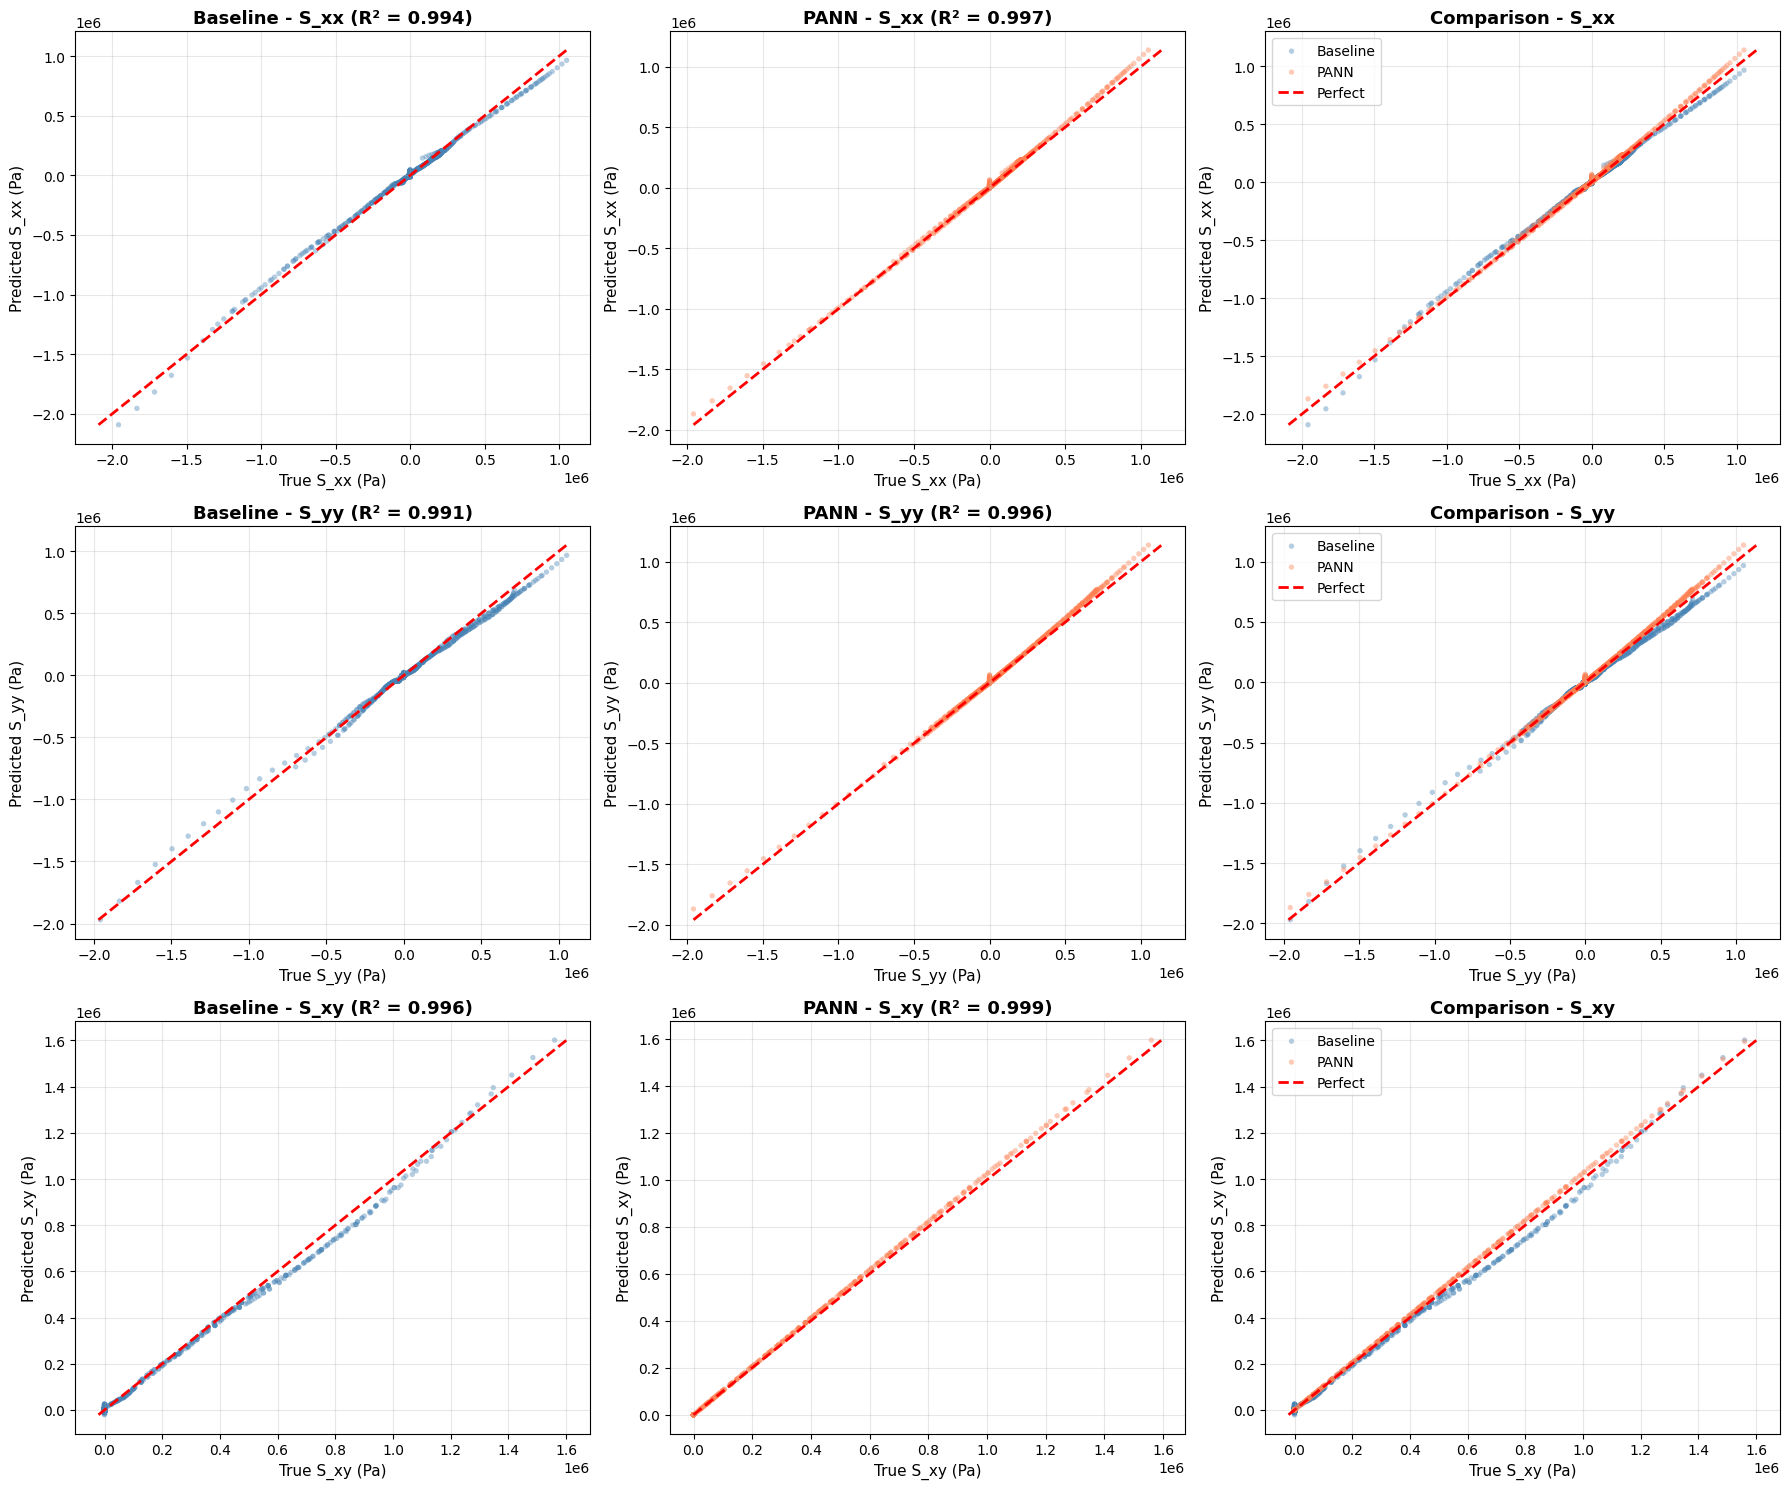

In [12]:
compare_predictions(y_test_seen, y_pred_baseline_seen, y_pred_pann_seen)

## 8. Residual Distribution Comparison (Seen Scenarios)

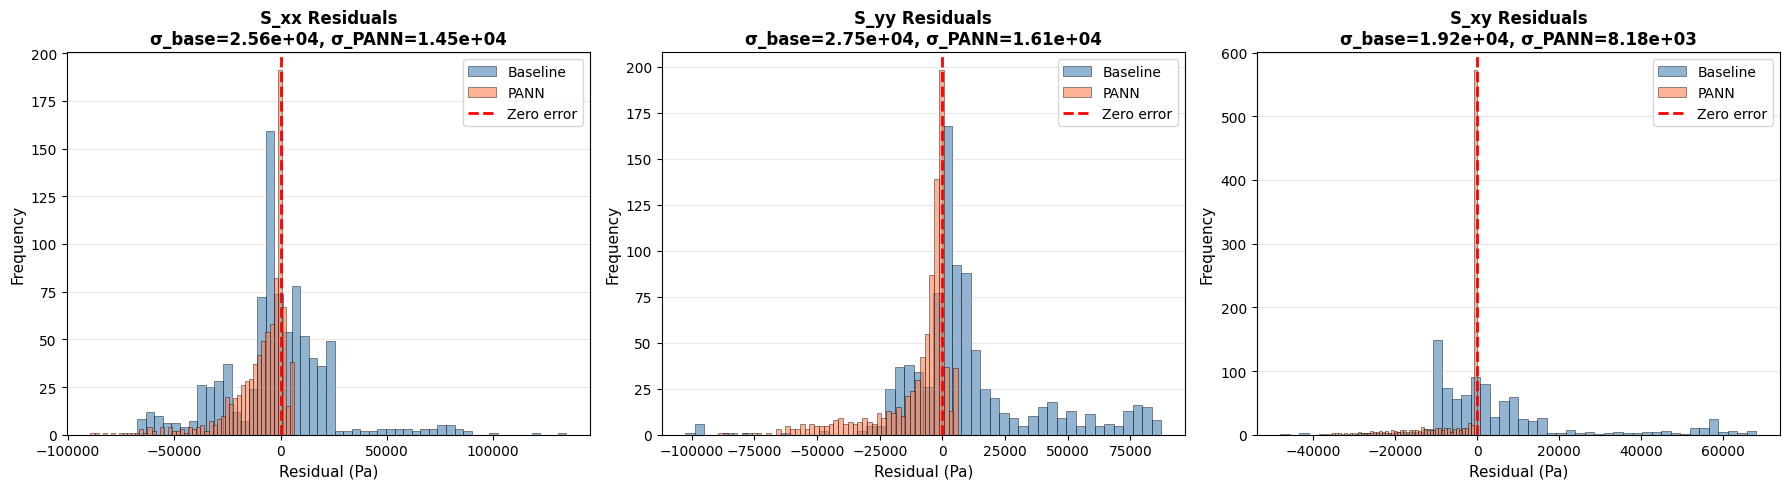

In [13]:
compare_residuals(y_test_seen, y_pred_baseline_seen, y_pred_pann_seen)

## 9. Metrics Comparison (Seen Scenarios)

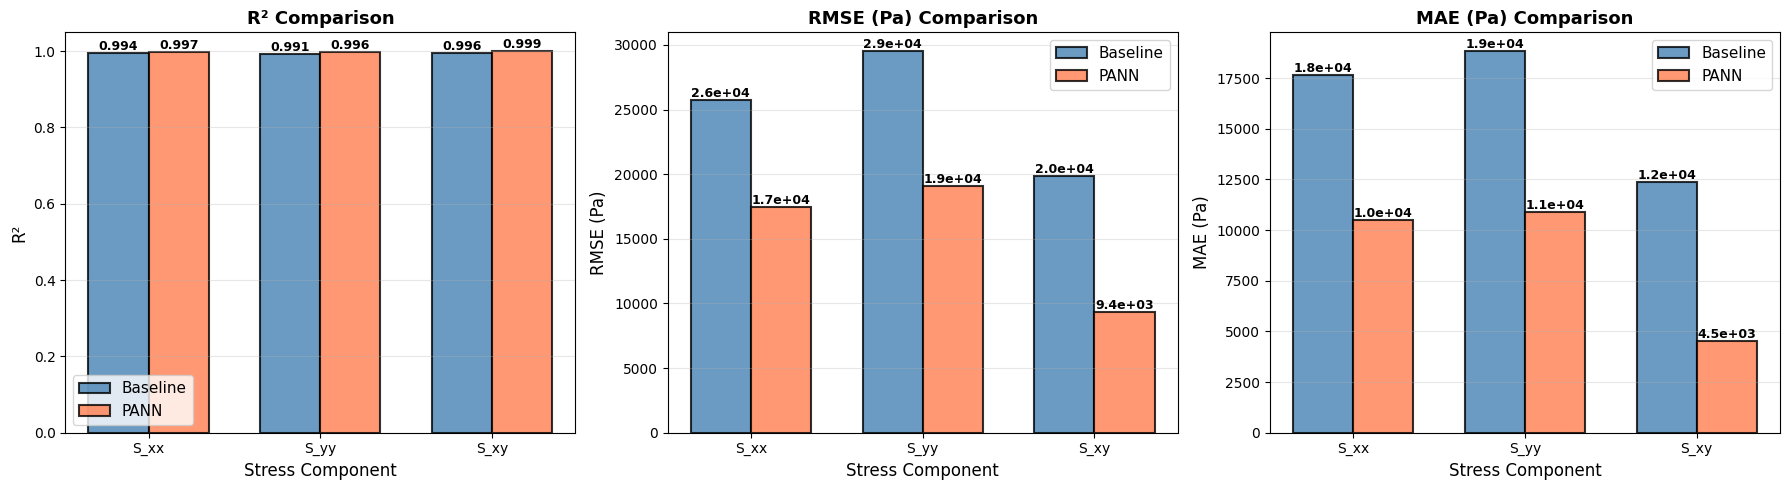

In [14]:
compare_metrics(baseline_metrics_seen, pann_metrics_seen)

## 10. Error Distribution Box Plots (Seen Scenarios)

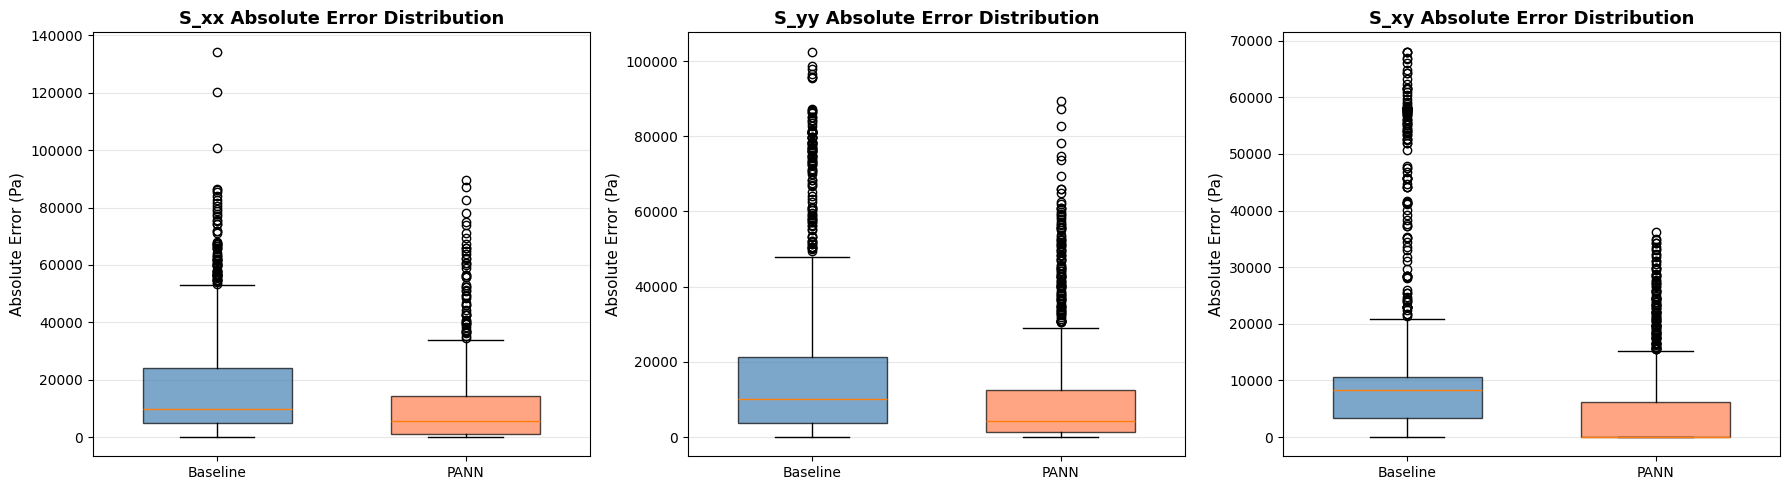

In [15]:
plot_error_distribution_comparison(y_test_seen, y_pred_baseline_seen, y_pred_pann_seen)

## 11. Per-Component Analysis (Seen Scenarios)

In [16]:
import pandas as pd

# Create detailed comparison table for seen scenarios
components = stress_names
comparison_data = []

for comp in components:
    comparison_data.append({
        'Component': comp,
        'Baseline R² (Seen)': f"{baseline_metrics_seen['components'][comp]['r2']:.4f}",
        'PANN R² (Seen)': f"{pann_metrics_seen['components'][comp]['r2']:.4f}",
        'Baseline R² (Unseen)': f"{baseline_metrics_unseen['components'][comp]['r2']:.4f}",
        'PANN R² (Unseen)': f"{pann_metrics_unseen['components'][comp]['r2']:.4f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nPer-Component R² Comparison (Seen vs Unseen):")
print(comparison_df.to_string(index=False))


Per-Component R² Comparison (Seen vs Unseen):
Component Baseline R² (Seen) PANN R² (Seen) Baseline R² (Unseen) PANN R² (Unseen)
     S_xx             0.9939         0.9972               0.8662           0.9912
     S_yy             0.9910         0.9962               0.8177           0.9886
     S_xy             0.9959         0.9991               0.5558           0.9975


## 12. Statistical Significance Tests (Optional)

In [17]:
from scipy import stats

# Paired t-test on absolute errors (seen scenarios)
errors_baseline_seen = np.abs(y_test_seen - y_pred_baseline_seen)
errors_pann_seen = np.abs(y_test_seen - y_pred_pann_seen)

print("Paired t-test on absolute errors (Seen Scenarios):")
for i, comp in enumerate(stress_names):
    t_stat, p_value = stats.ttest_rel(errors_baseline_seen[:, i], errors_pann_seen[:, i])
    print(f"  {comp}: t={t_stat:.4f}, p={p_value:.4e}")
    if p_value < 0.05:
        better_model = "Baseline" if errors_baseline_seen[:, i].mean() < errors_pann_seen[:, i].mean() else "PANN"
        print(f"    → {better_model} is significantly better (p < 0.05)")
    else:
        print(f"    → No significant difference")

Paired t-test on absolute errors (Seen Scenarios):
  S_xx: t=15.9171, p=2.7792e-50
    → PANN is significantly better (p < 0.05)
  S_yy: t=15.0913, p=6.6373e-46
    → PANN is significantly better (p < 0.05)
  S_xy: t=22.1000, p=2.5178e-86
    → PANN is significantly better (p < 0.05)


## 13. Side-by-Side Predictions (Unseen Scenarios)

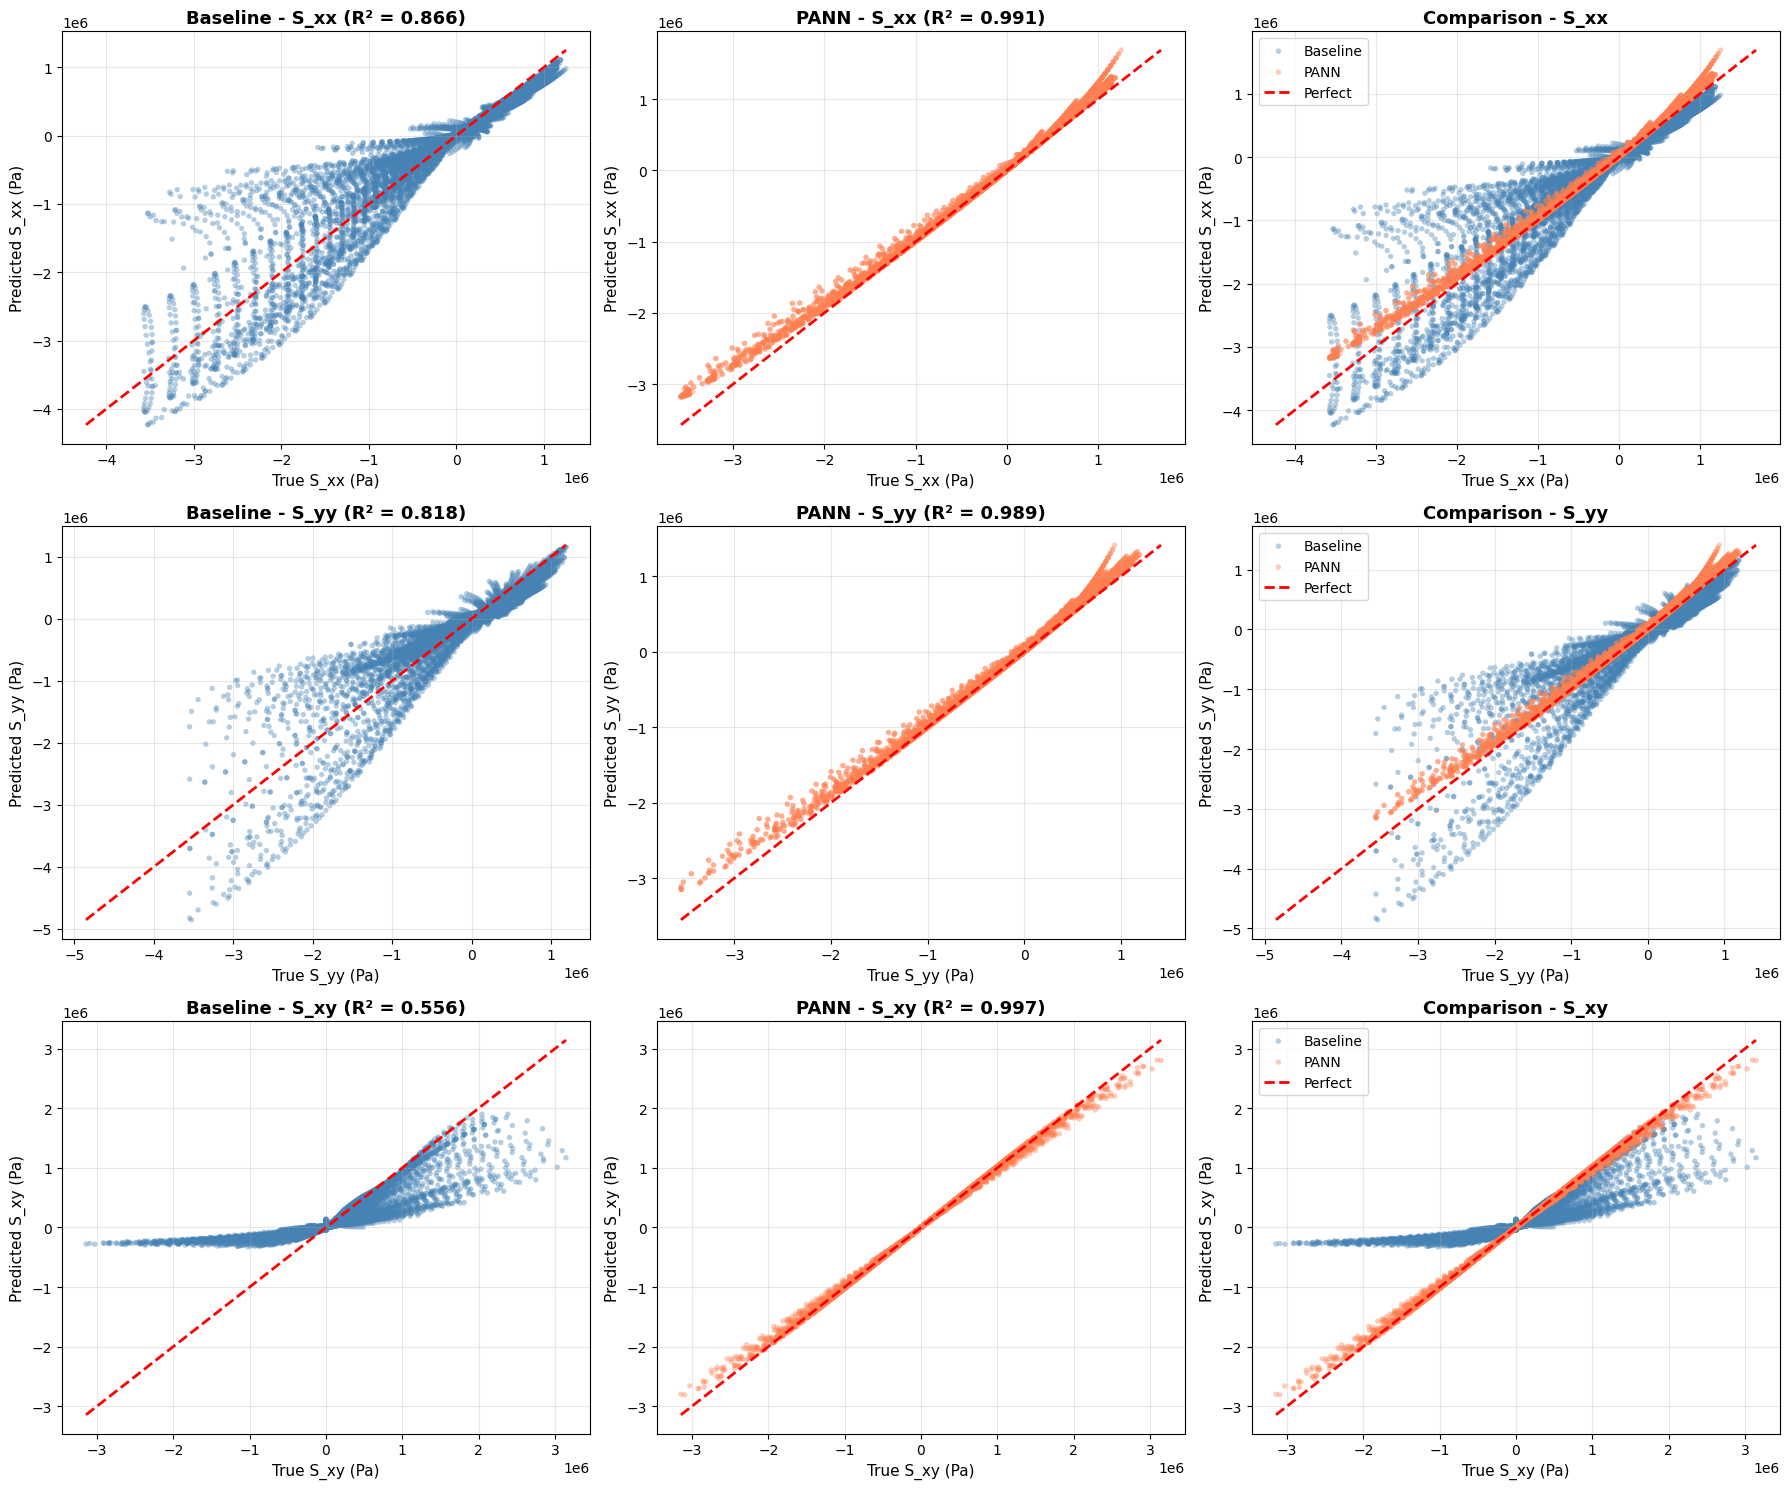

In [18]:
# Get predictions for unseen test scenarios
y_test_unseen = data_baseline_unseen['y_test_original']
y_pred_baseline_unseen = baseline_model.predict(data_baseline_unseen['X_test'], verbose=0)
y_pred_baseline_unseen = data_baseline_unseen['y_scaler'].inverse_transform(y_pred_baseline_unseen)

y_pred_pann_unseen = pann_model.predict(data_pann_unseen['X_test'], verbose=0)

compare_predictions(y_test_unseen, y_pred_baseline_unseen, y_pred_pann_unseen)

## 14. Residual Distribution Comparison (Unseen Scenarios)

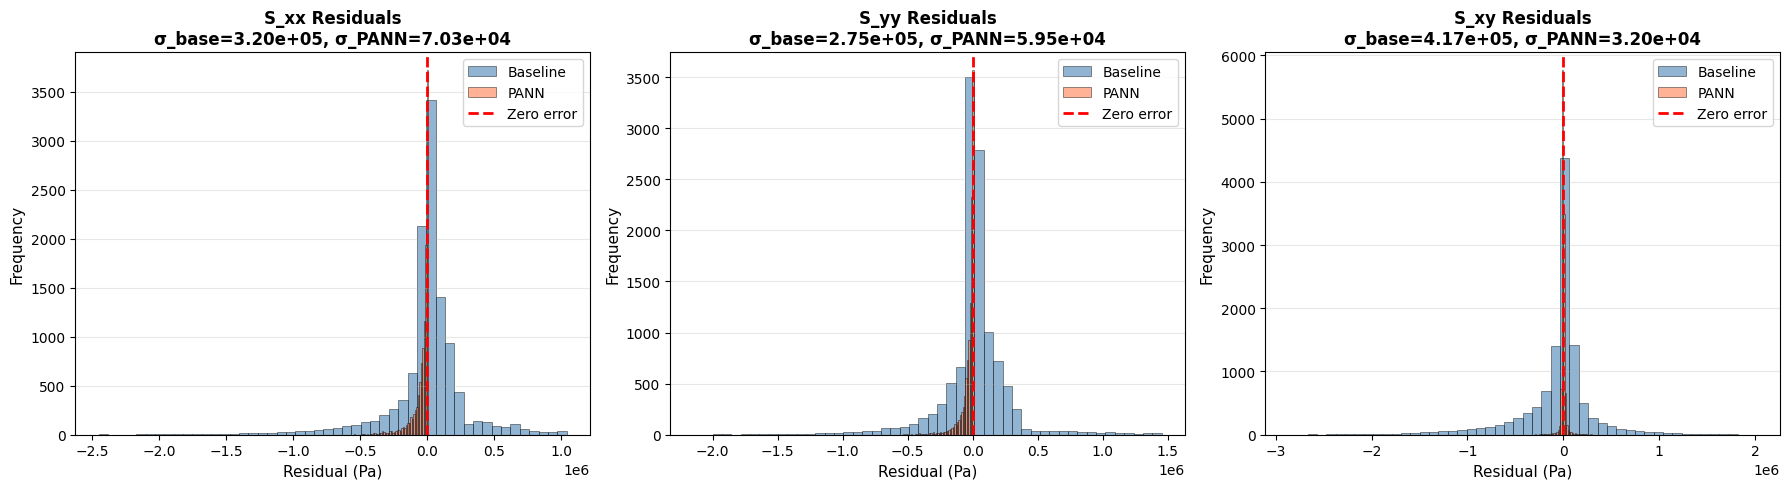

In [19]:
compare_residuals(y_test_unseen, y_pred_baseline_unseen, y_pred_pann_unseen)

## 15. Metrics Comparison (Unseen Scenarios)

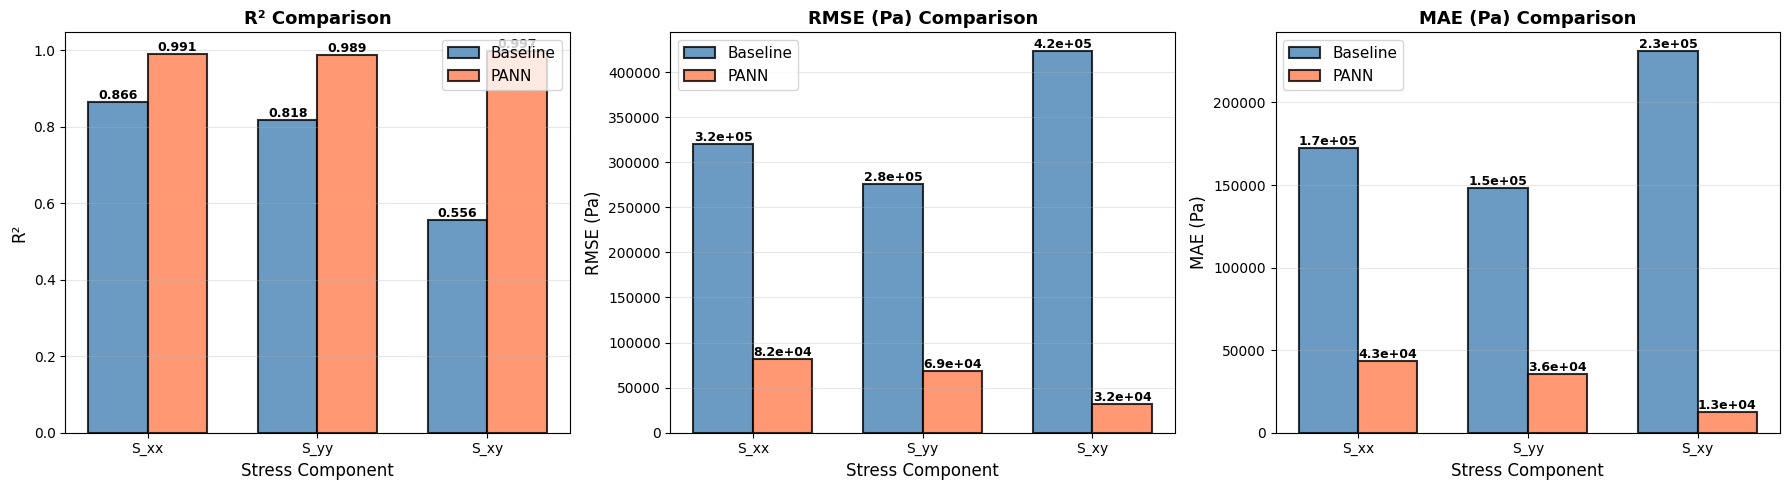

In [20]:
compare_metrics(baseline_metrics_unseen, pann_metrics_unseen)

## 16. Error Distribution Box Plots (Unseen Scenarios)

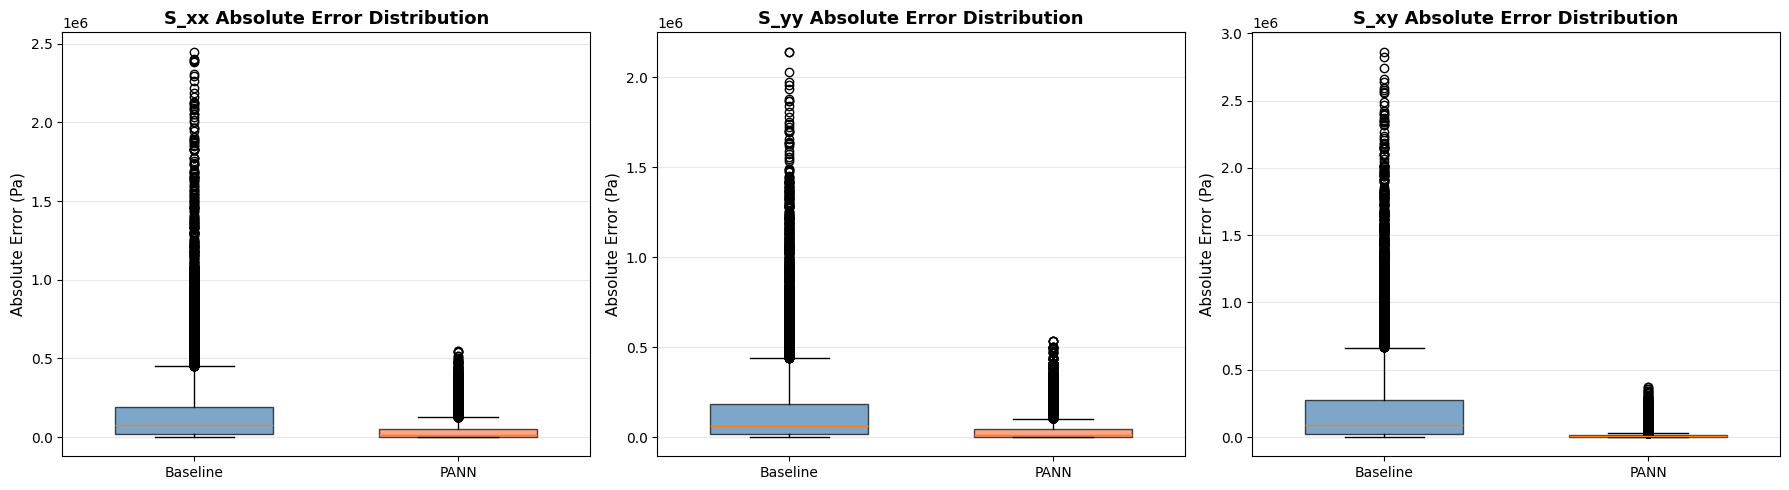

In [21]:
plot_error_distribution_comparison(y_test_unseen, y_pred_baseline_unseen, y_pred_pann_unseen)

## 17. Per-Component Analysis (Unseen Scenarios)

In [22]:
# Create detailed comparison table for unseen scenarios
components = stress_names
comparison_data_unseen = []

for comp in components:
    comparison_data_unseen.append({
        'Component': comp,
        'Baseline R² (Unseen)': f"{baseline_metrics_unseen['components'][comp]['r2']:.4f}",
        'PANN R² (Unseen)': f"{pann_metrics_unseen['components'][comp]['r2']:.4f}",
        'Baseline MAE (Unseen)': f"{baseline_metrics_unseen['components'][comp]['mae']:.2e}",
        'PANN MAE (Unseen)': f"{pann_metrics_unseen['components'][comp]['mae']:.2e}"
    })

comparison_df_unseen = pd.DataFrame(comparison_data_unseen)
print("\nPer-Component Metrics (Unseen Scenarios):")
print(comparison_df_unseen.to_string(index=False))


Per-Component Metrics (Unseen Scenarios):
Component Baseline R² (Unseen) PANN R² (Unseen) Baseline MAE (Unseen) PANN MAE (Unseen)
     S_xx               0.8662           0.9912              1.72e+05          4.35e+04
     S_yy               0.8177           0.9886              1.48e+05          3.56e+04
     S_xy               0.5558           0.9975              2.31e+05          1.26e+04


## 18. Statistical Significance Tests - Unseen Scenarios (Optional)

In [23]:
# Paired t-test on absolute errors (unseen scenarios)
from scipy import stats

errors_baseline_unseen = np.abs(y_test_unseen - y_pred_baseline_unseen)
errors_pann_unseen = np.abs(y_test_unseen - y_pred_pann_unseen)

print("Paired t-test on absolute errors (Unseen Scenarios):")
for i, comp in enumerate(stress_names):
    t_stat, p_value = stats.ttest_rel(errors_baseline_unseen[:, i], errors_pann_unseen[:, i])
    print(f"  {comp}: t={t_stat:.4f}, p={p_value:.4e}")
    if p_value < 0.05:
        better_model = "Baseline" if errors_baseline_unseen[:, i].mean() < errors_pann_unseen[:, i].mean() else "PANN"
        print(f"    → {better_model} is significantly better (p < 0.05)")
    else:
        print(f"    → No significant difference")

Paired t-test on absolute errors (Unseen Scenarios):
  S_xx: t=58.9877, p=0.0000e+00
    → PANN is significantly better (p < 0.05)
  S_yy: t=62.4687, p=0.0000e+00
    → PANN is significantly better (p < 0.05)
  S_xy: t=70.2710, p=0.0000e+00
    → PANN is significantly better (p < 0.05)
